# Import des librairies

In [1]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import sklearn

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


import seaborn as sns

import string
import re

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

#Scikit-learn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

# Modèles de Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
#print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_hub version:", hub.__version__)
print("tensorflow_text version:", text.__version__)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.2.2
numpy version: 2.0.2
skearn version: 1.6.1
re version: 2.2.1
tensorflow version: 2.18.0
tensorflow_hub version: 0.16.1
tensorflow_text version: 2.18.1
CPU times: user 7.46 s, sys: 1.79 s, total: 9.25 s
Wall time: 13.2 s


# Chargement des données

In [2]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [3]:
for name in ["tweets_df_tfidf_1gram", "embeddings_bert", "embeddings_fasttext", "embeddings_word2vec"]:
    size = os.path.getsize(os.path.join(path, f"{name}.npy")) / 1e6
    print(f"{name}: {size:.2f} MB")

tweets_df_tfidf_1gram: 80.46 MB
embeddings_bert: 30.72 MB
embeddings_fasttext: 3823.37 MB
embeddings_word2vec: 3823.37 MB


In [4]:
%%time
tweets_df_tfidf_1gram = np.load(os.path.join(path, "tweets_df_tfidf_1gram.npy"), allow_pickle=True)

tweets_embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"), allow_pickle=True)
tweets_embeddings_fasttext = np.load(os.path.join(path, "embeddings_fasttext.npy"), mmap_mode='r')
tweets_embeddings_word2vec = np.load(os.path.join(path, "embeddings_word2vec.npy"), mmap_mode='r')

CPU times: user 5.48 ms, sys: 665 ms, total: 670 ms
Wall time: 1.25 s


In [5]:
print(tweets_df_tfidf_1gram.item().shape)
print(tweets_embeddings_word2vec.shape)
print(tweets_embeddings_fasttext.shape)
print(tweets_embeddings_bert.shape)

(1593071, 500)
(1593071, 300)
(1593071, 300)
(10000, 768)


> Chargement de la variable cible

In [6]:
# Variable cible
Y = np.load(os.path.join(path, "targets.npy"), allow_pickle=True)
display(Y.shape)

(1593071,)

In [7]:
def plot_distribution(y_train, y_val, y_test):
  # Création des distributions
  dist_df = pd.DataFrame({
      "Train set": pd.Series(y_train).value_counts(normalize=True),
      "Validation set": pd.Series(y_val).value_counts(normalize=True),
      "Test set": pd.Series(y_test).value_counts(normalize=True)
  }).T

  # Optionnel : renommer les colonnes
  #dist_df.columns = ["Classe 1", "Classe 0"]

  # Barplot
  dist_df.plot(kind="bar", figsize=(8, 5), colormap="Set2")
  plt.title("Répartition des classes dans y_train, y_val et y_test")
  plt.ylabel("Proportion")
  plt.xticks(rotation=0)
  plt.ylim(0, 1)
  plt.legend(title="Classe")
  plt.tight_layout()
  plt.show()


def split_train_val_test(X, y, sample_size=None, test_size=0.2, val_size=0.2, random_state=42):
    """
    Splitte un jeu de données en trois sous-ensembles : train, validation et test.

    Paramètres :
    -----------
    X : array-like ou sparse matrix
        Matrice des features (peut être dense ou sparse).

    y : array-like
        Vecteur cible (labels ou classes).

    sample_size : int ou None (default=None)
        Si spécifié, un sous-échantillon (stratifié) de cette taille est prélevé depuis X/y avant le split.

    test_size : float (default=0.2)
        Proportion du test set par rapport à l'ensemble X (ou X échantillonné).

    val_size : float (default=0.2)
        Proportion du validation set par rapport à (train + val).

    random_state : int (default=42)
        Graine pour la reproductibilité.

    Retourne :
    ---------
    X_train, X_val, X_test, y_train, y_val, y_test : datasets splités avec stratification.
    """

    if sample_size is not None:
        X_sample, _, y_sample, _ = train_test_split(
            X, y, train_size=sample_size, stratify=y, random_state=random_state
        )
    else:
        X_sample, y_sample = X, y

    # Split temporaire : train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_sample, y_sample, test_size=test_size, stratify=y_sample, random_state=random_state
    )

    # Split train vs validation (sur le train_val)
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_split, stratify=y_train_val, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Approche 1: Modéle sur mesure

- Logistic Regression
- Ridge Classifier
- Naive Bayes
- Light Gradient Boosting Machine
- Gradient Boosting Classifier
- linear discriminant analysis

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_jobs=-1),
    "LightGBM": LGBMClassifier(verbose=-1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

In [9]:
from tqdm import tqdm
tqdm.pandas()
def evaluate_models(x_train, x_valid, y_train, y_valid, cv=3, scoring="accuracy"):
    results = []

    for name, model in tqdm(models.items()):
      start_time = time.time()
      print(f"Evaluating {name}...")
      scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
      y_pred = model.fit(x_train, y_train).predict(x_valid)
      results.append({
          "Model": name,
          "score": model.score(x_valid, y_valid),
          "precision": precision_score(y_valid, y_pred),
          "recall": recall_score(y_valid, y_pred),
          "f1": f1_score(y_valid, y_pred),
          "auc": roc_auc_score(y_valid, y_pred),
          "mse": mean_squared_error(y_valid, y_pred),
          "train_time (s)": time.time() - start_time
      })
    print("\n")

    return pd.DataFrame(results).sort_values(by="score", ascending=False)

def show_calibration_curve(models, X_valid, y_valid, exclude=None):
  if exclude is None:
    exclude = []
  fig = plt.figure(figsize=(16, 10))
  gs = GridSpec(7, 3)
  colors = plt.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  markers = ["^", "v", "s", "o", "2"]
  for i, (name, clf) in enumerate(models.items()):
    if name not in exclude:
      display = CalibrationDisplay.from_estimator(
          clf,
          X_valid,
          y_valid,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
          marker=markers[i],
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

skf = StratifiedKFold(n_splits=4)

## | Tf-idf

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


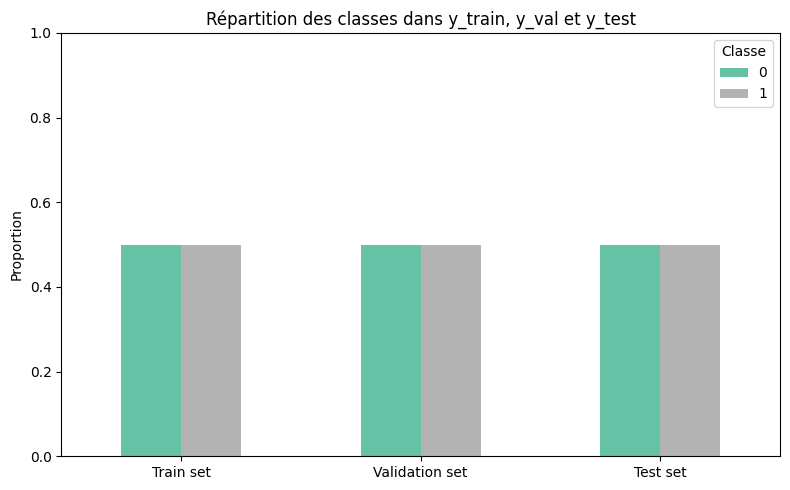

In [10]:
X_train_tfidf, X_valid_tfidf, X_test_tfidf, y_train_tfidf, y_valid_tfidf, y_test_tfidf = split_train_val_test(tweets_df_tfidf_1gram.item(), Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_tfidf).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_tfidf).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_tfidf).value_counts(normalize=True))
plot_distribution(y_train_tfidf, y_valid_tfidf, y_test_tfidf)

In [11]:
skf.get_n_splits(X_train_tfidf, y_train_tfidf)
for i, (train_index, test_index) in enumerate(skf.split(X_train_tfidf, y_train_tfidf)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 2890  2891  2892 ... 11997 11998 11999]
  Test:  index=[   0    1    2 ... 3107 3108 3109]
Fold 1:
  Train: index=[    0     1     2 ... 11997 11998 11999]
  Test:  index=[2890 2891 2892 ... 5997 5999 6000]
Fold 2:
  Train: index=[    0     1     2 ... 11997 11998 11999]
  Test:  index=[5998 6001 6002 ... 8999 9001 9004]
Fold 3:
  Train: index=[   0    1    2 ... 8999 9001 9004]
  Test:  index=[ 8994  8995  9000 ... 11997 11998 11999]


In [12]:
%%time
tfidf_results_df = evaluate_models(X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf, cv=skf)

 20%|██        | 1/5 [00:00<00:00,  6.76it/s]

Evaluating Logistic Regression...
Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:00<00:00,  6.95it/s]

Evaluating XGBoost...


 60%|██████    | 3/5 [00:12<00:11,  5.80s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [00:17<00:05,  5.24s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [00:55<00:00, 11.20s/it]



CPU times: user 1min 8s, sys: 218 ms, total: 1min 9s
Wall time: 56 s


In [13]:
tfidf_results_df

,Model,score,precision,recall,f1,auc,mse,train_time (s)
1,Ridge Classifier,0.71225,0.700141,0.7425,0.720699,0.71225,0.28775,0.135409
0,Logistic Regression,0.71025,0.698443,0.7400,0.718621,0.71025,0.28975,0.147905
3,LightGBM,0.70150,0.685373,0.7450,0.713943,0.70150,0.29850,4.377611
4,Random Forest,0.69050,0.691843,0.6870,0.689413,0.69050,0.30950,38.776601
2,XGBoost,0.68900,0.668449,0.7500,0.706880,0.68900,0.31100,12.520846


## | Word2Vec

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


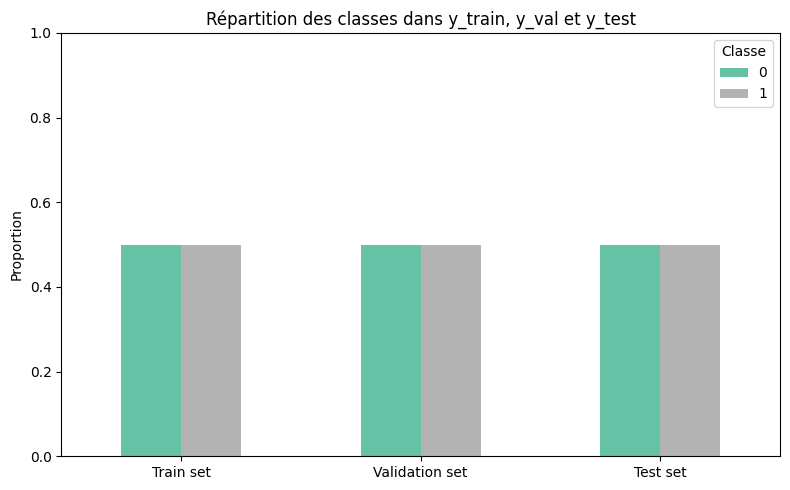

CPU times: user 2.74 s, sys: 6.11 s, total: 8.85 s
Wall time: 55.9 s


In [14]:
%%time
X_train_w2v, X_valid_w2v, X_test_w2v, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tweets_embeddings_word2vec, Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_w2v).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_w2v).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_w2v).value_counts(normalize=True))
plot_distribution(y_train_w2v, y_valid_w2v,  y_test_w2v)

In [15]:
%%time
w2v_results__df = evaluate_models(X_train_w2v, X_valid_w2v, y_train_w2v, y_valid_w2v, cv=skf)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 20%|██        | 1/5 [00:16<01:04, 16.23s/it]

Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:18<00:23,  7.92s/it]

Evaluating XGBoost...


 60%|██████    | 3/5 [01:36<01:19, 39.89s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [02:14<00:39, 39.17s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [04:23<00:00, 52.76s/it]



CPU times: user 5min 54s, sys: 1.32 s, total: 5min 55s
Wall time: 4min 23s


In [16]:
w2v_results__df

,Model,score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.72775,0.721655,0.7415,0.731443,0.72775,0.27225,16.234023
1,Ridge Classifier,0.72250,0.717285,0.7345,0.725791,0.72250,0.27750,2.103240
3,LightGBM,0.69725,0.699142,0.6925,0.695805,0.69725,0.30275,38.061322
2,XGBoost,0.69375,0.698616,0.6815,0.689952,0.69375,0.30625,77.929830
4,Random Forest,0.69225,0.706166,0.6585,0.681501,0.69225,0.30775,129.433864


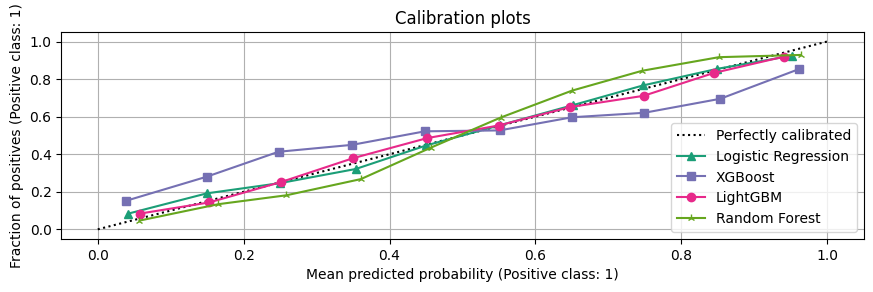

In [17]:
show_calibration_curve(models, X_test_w2v, y_test_w2v, exclude=["Ridge Classifier"])

## | FastText

In [18]:
%%time
X_train_ft, X_valid_ft, X_test_ft, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tweets_embeddings_fasttext, Y, sample_size=20000)

CPU times: user 4.75 s, sys: 23.3 s, total: 28 s
Wall time: 4min 58s


In [19]:
%%time
ft_results_df = evaluate_models(X_train_ft, X_valid_ft, y_train_ft, y_valid_ft, cv=skf)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 20%|██        | 1/5 [00:31<02:07, 31.77s/it]

Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:32<00:40, 13.64s/it]

Evaluating XGBoost...


 60%|██████    | 3/5 [01:53<01:28, 44.18s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [02:31<00:41, 41.80s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [04:41<00:00, 56.39s/it]



CPU times: user 6min 26s, sys: 1.2 s, total: 6min 27s
Wall time: 4min 41s


In [20]:
display(ft_results_df)

,Model,score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.72125,0.720259,0.7235,0.721876,0.72125,0.27875,31.768719
1,Ridge Classifier,0.72100,0.721000,0.7210,0.721000,0.72100,0.27900,0.943762
2,XGBoost,0.69600,0.695414,0.6975,0.696455,0.69600,0.30400,80.519969
3,LightGBM,0.69525,0.697521,0.6895,0.693488,0.69525,0.30475,38.159950
4,Random Forest,0.68250,0.696448,0.6470,0.670814,0.68250,0.31750,130.554987


# Approche 2: Modèle sur mesure avancé (Reseau de Neurone)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

def build_model(embeddings, input_dim=300, output_dim=300):
  model = Sequential()
  model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_dim))
  model.add(Bidirectional(LSTM(64, return_sequences=False)))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # pour classification binaire

  return model

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

NameError: name 'model' is not defined

## | Word2Vec

## | FastText